In [84]:
import numpy as np
import igraph as ig
from ripser import ripser
from persim import plot_diagrams
from numba import jit
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/CarolineHerr/Documents/GitHub/Preferential_Attachment_Clique_Complex')
from simulator_pa import pa_generator
import betti

## Graph Generation and Parameter Selection

We'll first generate a scale-free graph using preferential attachment using the function pa_generator, which can be found in simulator_pa.py. (cite section from paper). The function will output an iGraph object simulated using the preferential attachment model.

The necessary parameters are:

num_nodes (int): Number of nodes in the graph (referred as $t$, i.e. how long the model is simulated for).

num_edges_per_new_node (int): Number of edges attached to the new node each time (referred as $m$).

$\delta$ (float): Parameter to control the rich-gets-richer effect. For smaller (more negative) delta, the effect is stronger.
        The power of of the tail of the degree distribution should be $\tau = 3 + \delta / m$.
        We choose -m < $\delta$ < 0 to ensure 2 < $\tau$ < 3.
        
seed (int): Seed for the random number geneator.

Because we're interested in the homology of the complex and scale-free network, we tend to select large m and smaller $\delta$ for more interesting results. 

In this tutorial, we'll work with $m = 7, \delta = -5$.

In order to make the visualize more interpretable, we'll use smaller num_nodes.


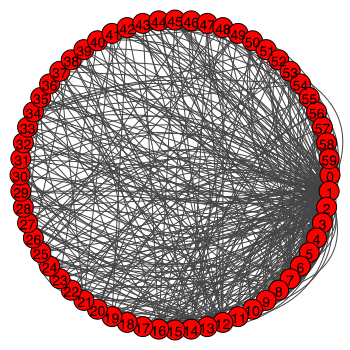

In [85]:
m = 7
delta = -5
T0 = 60
seed = 100
graph = pa_generator(T0, m, delta, seed)
layout = graph.layout_circle()
labels = [x for x in range(T0)]
ig.plot(graph, layout=layout, vertex_label = labels, bbox=(0, 0, 350, 350))

We can observe from the plot that the graph is likely scale-free, since there are a few nodes (typically nodes appearing early) with very high degrees, while the rest have lower degrees. We'll now generate a graph with larger t, with other parameters staying the same, to produce more interesting results about homology.

In [83]:
T = 20000
graph = pa_generator(T, m, delta, seed)

## Betti Numbers Calculation

We'll now calculate the Betti numbers using Ripser, which helps us obtain the persistence diagram of the complex. In this example, we'll focus on Betti numbers at the 2nd dimension.

We'll first demonstrate Ripser in a simple example, with four nodes and four edges forming a square.

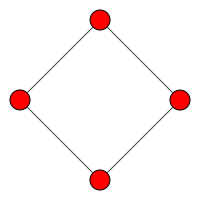

In [70]:
small_graph = ig.Graph()
small_graph.add_vertices(4)
small_graph.add_edges([(0,1), (1,2), (2,3), (3,0)])
ig.plot(small_graph, bbox=(0, 0, 200, 200))

To use Ripser, we'll use the function get_adge_matrix() from betti.py, which constructs a matrix describing the age of each edge and vertex. Ripser takes the matrix and a maximum dimension as inputs to form the persistent diagram. The function translate_PD_to_betti() takes the persistent diagram and t as an input to calculate the betti number.

Betti 1 at each time is: [0. 0. 0. 1.]


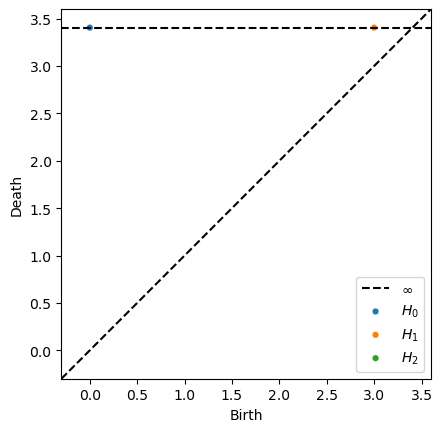

In [71]:
mat = betti.get_age_matrix(small_graph)
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
print('Betti 1 at each time is: ' + str(betti.translate_PD_to_betti(dgms[1], 4)))
plot_diagrams(dgms)

The orange dot indicates that a 1-dim hole is born at time = 3, as the square is formed. Betti 1 is calculated to be [0,0,0,1], since the first hole appears at time = 3. Now, let's fill the square and see what happens.

Betti 1 at each time is: [0. 0. 0. 1. 0.]


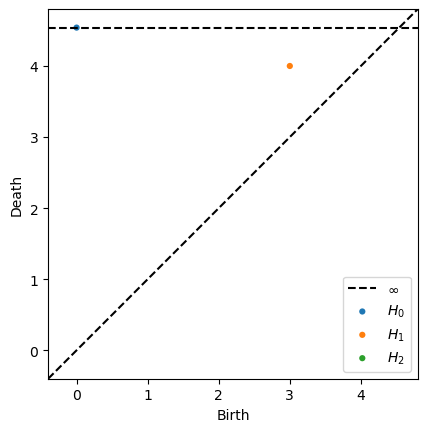

In [72]:
small_graph.add_vertices(1)
small_graph.add_edges([(4,0),(4,1),(4,2),(4,3)])
mat = betti.get_age_matrix(small_graph)
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
print('Betti 1 at each time is: ' + str(betti.translate_PD_to_betti(dgms[1], 5)))
plot_diagrams(dgms)

Since the square is filled by the new node, the hole we saw previously "dies" at time = 4, so the orange dot is shown to be born at time = 3, and dies at time = 4. Correspondingly, Betti 1 goes back to 0 at time = 4.

Now, let's do the same calculation for our larger graph.

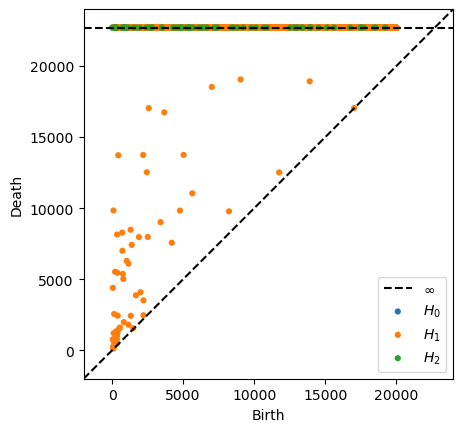

In [42]:
mat = betti.get_age_matrix(graph) # obtain the age matrix of the complex as an input for ripser
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms'] # get the persistence diagrams
plot_diagrams(dgms)

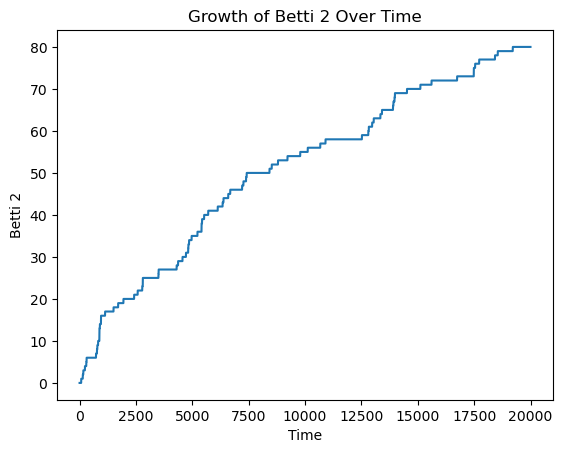

In [43]:
betti2_actual = betti.translate_PD_to_betti(dgms[2], T) # read the betti numbers from persistence diagrams
plt.plot(betti2_actual)
plt.xlabel('Time')
plt.ylabel('Betti 2')
plt.title('Growth of Betti 2 Over Time')
plt.show()

## Upper Bound of Betti Number

The above plot shows the growth of 2nd dimensional betti numbers over time. We'll now investigate the upper bounds and lower bounds. The detailed proofs for the bounds can be found in the paper in section 4 and 5.

The upper bound is found by $$\beta_q \leq \sum_{t \leq T} \text{rk } H_{q-1}(L^{(t)})$$ 
i.e., the cumulative sum of Betti q-1 of each node's link, where q represents the dimension (2 in our case).

In [44]:
def betti2_upper_bound(graph):
    """
    Return the upper bound for Betti 2 by finding the cumulative sum of Betti 1 of each node's link
    
    OUTPUT
    betti 2 upper bound at each time step as a list
    
    INPUT
    graph: igraph object
    
    """

    edge_list = np.array([e.tuple for e in graph.es])
    start = 0
    num_edges_per_new_node = int(len(edge_list)/(edge_list[-1][1]))
    end = num_edges_per_new_node
    new_betti1_in_batch = [0]

    while start < len(edge_list) and end <= len(edge_list):
        # find the link of each node
        link_list = edge_list[start:end, 0]
        link_list = np.unique(link_list)

        # generate subgraph for the link
        subgraph = graph.induced_subgraph(link_list)

        # count the betti numbers
        mat = betti.get_age_matrix(subgraph)
        dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']

        betti1 = 0
        for k, j in dgms[1]:
            betti1 += 1
            if j < float('inf'):
                betti1 -= 1

        new_betti1_in_batch.append(betti1)
        start += num_edges_per_new_node
        end += num_edges_per_new_node
    return np.cumsum(new_betti1_in_batch)

betti2_upper = betti2_upper_bound(graph)

## Lower Bound of Betti Number

The lower bound consists of three terms: $$\beta_q \geq \sum_{t \leq T} (l^{(t)} - b^{(t)}_{MC} - b^{(t)}_{KL})$$ where $$l^{(t)} = \mathbf{1}[(S^q)^{(t)}] $$

$$b^{(t)}_{MC} = \mathbf{1}[(S^q)^{(t)} \text{and rk ker }f_{q-1} = 0] $$

$$b^{(t)}_{KL} = \text{rk } H_q (L^{(t)})$$

Please refer to Proposition 14 in paper for explanations of notations and details.

In [51]:
# helper functions for lower bound calculation

@jit(nopython=True)
def first_term_lower_bound(square, largest_square_node, t, numba_flag=True, graph=None, edge_list=None, m=None, par_col=None):
    first_term = []
    for idx in range(largest_square_node+1):
        first_term.append(int(0))

    found_one_flag = 0
    for i in range(largest_square_node+1, t):
        if True:
            fill = betti.check_node_square_connection(
                edge_list, i, square, m=m)
        if fill:
            if found_one_flag == 0:  # The first filling does not count
                first_term.append(0)
                found_one_flag = 1
            else:
                first_term.append(1)
        else:
            first_term.append(0)

    return first_term

def second_term_lower_bound(graph, square, first_term):
    t = graph.vcount()
    edge_list = np.array([e.tuple for e in graph.es])
    largest_square_node = max(square)
    link_betti2 = [0 for idx in range(largest_square_node+1)]
    for i in range(largest_square_node + 1, t):
        if first_term[i] >= 1:
            mat = betti.get_link_matrix(graph, square, i)
            dgms = ripser(mat, distance_matrix=True, maxdim=1)['dgms']
            link_betti2.append(int(
                any([pt[1] == 2 for pt in dgms[1]])
            ))
        else:
            link_betti2.append(0)
    return np.cumsum(link_betti2)


In [52]:
def betti2_lower_bound(graph, time = 20):

    """
    Return the lower bound of Betti 2. 
    The lower bound is found by the above inequality.
    
    OUTPUT
    Betti 2 lower bound at each time step as a list
    
    INPUT
    graph: igraph object
    time: the time constraint for the appearance of the square
    """
    t = graph.vcount()
    
    # find if there's a square in the first 20 nodes
    boo, square = betti.check_square_appearance(graph, time)

    edge_list = np.array([e.tuple for e in graph.es])
    num_edges_per_new_node = int(len(edge_list)/(edge_list[-1][1]))
    if not boo:
        first_term_sum = np.array([0 for idx in range(t)])
    else:
        largest_square_node = max(square)
        first_term = first_term_lower_bound(np.array(
            square), largest_square_node, t, edge_list=edge_list, m=num_edges_per_new_node, par_col=0)
        first_term_sum = np.cumsum(first_term)

    if not boo:
        second_term = np.array([0 for idx in range(t)])
    else:
        second_term = second_term_lower_bound(
            graph, square, first_term)

    start = 0
    end = num_edges_per_new_node
    new_betti2_in_batch = [0]

    while start < len(edge_list) and end <= len(edge_list):
        link_list = edge_list[start:end, 0]
        link_list = np.unique(link_list)

        # generate subgraph for the link
        subgraph = graph.induced_subgraph(link_list)

        # count the betti numbers
        mat = betti.get_age_matrix(subgraph)
        dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
        new_betti2_in_batch.append(betti.translate_PD_to_betti(dgms[2], T))
        start += num_edges_per_new_node
        end += num_edges_per_new_node
    third_term = np.cumsum(new_betti2_in_batch)
    lower_bound = first_term_sum - second_term - third_term
    return lower_bound

betti2_lower = betti2_lower_bound(graph)

## Result Replications
Now, we can plot the the actual Betti numbers, the upper bound, and the lower bound to verify that the bounds hold for the graph we generated.

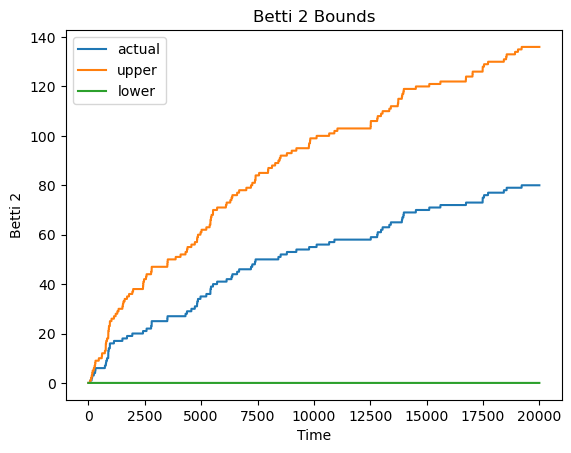

In [53]:
plt.plot(betti2_actual, label = 'actual')
plt.plot(betti2_upper, label = 'upper')
plt.plot(betti2_lower, label = 'lower')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Betti 2')
plt.title('Betti 2 Bounds')
plt.show()

We can repeat similar calculations to find the mean of Betti numbers to observe behavior. The simulation we used in the paper generates 500 graphs of T = 10^4, and takes the sample mean of the Betti numbers. We'll follow the same parameter, but the simulation could take a very long time. Feel free to modify the parameters to reduce the runtime. 

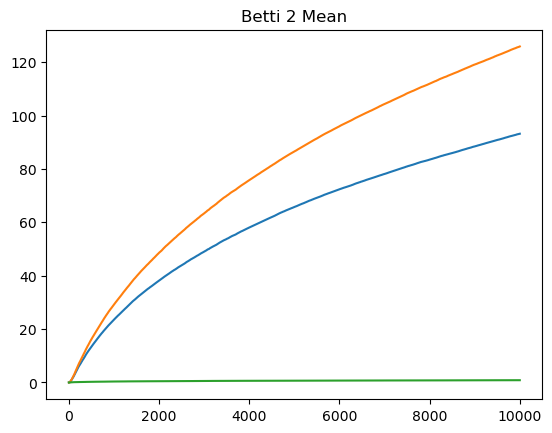

In [66]:
n_samples = 500
T = 10000
betti2_actual_mean = np.zeros(T)
betti2_upper_mean = np.zeros(T)
betti2_lower_mean = np.zeros(T)
for n in range(n_samples):
    graph = pa_generator(T, m, delta, n**3)
    mat = betti.get_age_matrix(graph)
    dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
    betti2_actual_mean += betti.translate_PD_to_betti(dgms[2], T)
    betti2_upper_mean += betti2_upper_bound(graph)
    betti2_lower_mean += betti2_lower_bound(graph)
betti2_actual_mean /= n_samples
betti2_upper_mean /= n_samples
betti2_lower_mean /= n_samples
plt.plot(betti2_actual_mean, label = 'actual')
plt.plot(betti2_upper_mean, label = 'upper')
plt.plot(betti2_lower_mean, label = 'lower')
plt.title('Betti 2 Mean')
plt.show()

Although convergence is slow, it is obvious that the curves are concave, so the slopes are decreasing. 